In [1]:
# import packages needed 
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import mapclassify as mc
import shapely as shp
from legendgram import legendgram
import palettable.matplotlib as palmpl
import esda
import libpysal as lps

C:\ProgramData\Anaconda3\lib\site-packages\libpysal\examples\remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")


In [13]:
#Import data
os.chdir(r'E:\Desktop\data\公众号知乎技术推文\PyGIS\PyGIS-04\data')
zone = gpd.read_file('shoot.shp')
zone = zone.to_crs(epsg=4326)
zone.crs
zone[['GEO_ID','shoot_coun','pop','income','employ','edu','geometry']].head(5)

,GEO_ID,shoot_coun,pop,income,employ,edu,geometry
0,1400000US36085007700,5.0,1417.333333,66617.666667,47.733333,13.440145,"MULTIPOLYGON (((-74.08710 40.64033, -74.08721 ..."
1,1400000US36085000900,0.0,1697.666667,70920.000000,57.700000,24.632207,"MULTIPOLYGON (((-74.08720 40.63990, -74.08553 ..."
2,1400000US36085000700,3.0,5263.333333,52794.000000,55.633333,21.438313,"MULTIPOLYGON (((-74.08956 40.64728, -74.08940 ..."
3,1400000US36085000300,3.0,1966.000000,90573.666667,66.600000,45.733254,"MULTIPOLYGON (((-74.07377 40.64510, -74.07359 ..."
4,1400000US36085001100,1.0,3354.000000,64367.666667,57.033333,24.374192,"POLYGON ((-74.07793 40.63811, -74.07790 40.638..."


In [3]:
# calculate spatial weights
wq =  lps.weights.Queen.from_dataframe(zone)
wq.transform = 'r'
# calculate the spatial lag for y
y = zone['shoot_coun']
ylag = lps.weights.lag_spatial(wq, y)
ylag[:10]

('WARNING: ', 1662, ' is an island (no neighbors)')
('WARNING: ', 2080, ' is an island (no neighbors)')


C:\ProgramData\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 2 islands with ids: 1662, 2080.
  warnings.warn(message)


array([1. , 3. , 2. , 2.5, 2.5, 1.8, 0. , 0. , 0. , 0. ])

C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


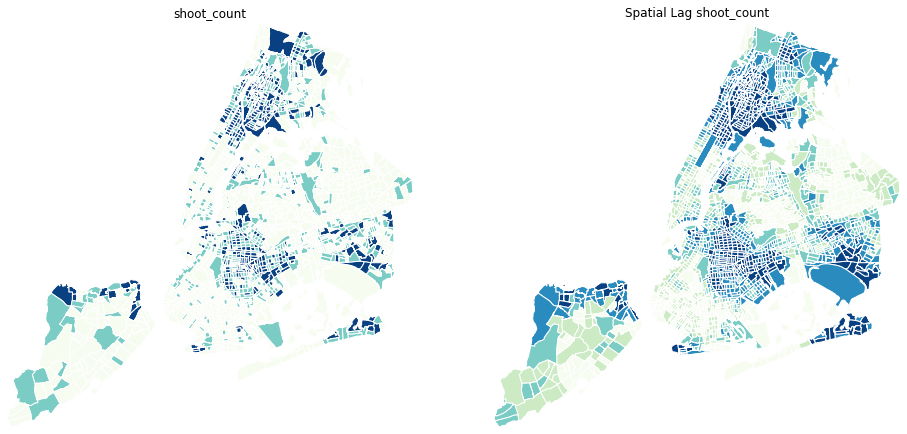

In [4]:
#Plot the shooting crimes hot maps
zone['lag_shoot_count'] = ylag
f,ax = plt.subplots(1,2,figsize=(16,10))
zone.plot(column='shoot_coun', ax=ax[0], edgecolor='white',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(zone.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("shoot_count")
zone.plot(column='lag_shoot_count', ax=ax[1], edgecolor='white',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(zone.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag shoot_count")
ax[0].axis('off')
ax[1].axis('off')
plt.show()
f.savefig('shoot_count.png', dpi=300)

### OLS Fitting

In [5]:
import statsmodels.formula.api as sm
reg = sm.ols(formula=" shoot_coun~ pop+income+employ+edu", data=zone).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             shoot_coun   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     124.0
Date:                Sat, 22 May 2021   Prob (F-statistic):           1.62e-95
Time:                        13:01:44   Log-Likelihood:                -4242.1
No. Observations:                2194   AIC:                             8494.
Df Residuals:                    2189   BIC:                             8523.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2276      0.244      9.147      0.0

### Geospatial Weighted Regression Model

In [6]:
import numpy as np
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import pandas as pd
import libpysal as ps

In [7]:
zone['centro']=zone.centroid
zone['X']=zone.centro.x
zone['Y']=zone.centro.y
coords = list(zip(zone['X'],zone['Y']))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [8]:
y = np.array(zone['shoot_coun']).reshape((-1,1))
pop = np.array(zone['pop']).reshape((-1,1))
income = np.array(zone['income']).reshape((-1,1))
employ = np.array(zone['employ']).reshape((-1,1))
edu = np.array(zone['edu']).reshape((-1,1))
X = np.hstack([pop, income,employ, edu])

In [9]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = y.reshape((-1,1))
y = (y - y.mean(axis=0)) / y.std(axis=0)
sel = Sel_BW(coords, y, X)
bw = sel.search()
print('bw:', bw)
gwr = GWR(coords, y, X, bw)
gwr_results = gwr.fit()
print('aicc:', gwr_results.aicc)
print('ENP:', gwr_results.ENP)
print('sigma2:', gwr_results.sigma2)

bw: 98.0
aicc: 4958.978176802648
ENP: 273.2466475928413
sigma2: 0.48167672342090795


In [10]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2194
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1788.638
Log-likelihood:                                                   -2889.065
AIC:                                                               5788.129
AICc:                                                              5790.168
BIC:                                                             -15052.394
R2:                                                                   0.185
Adj. R2:                                                              0.183

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

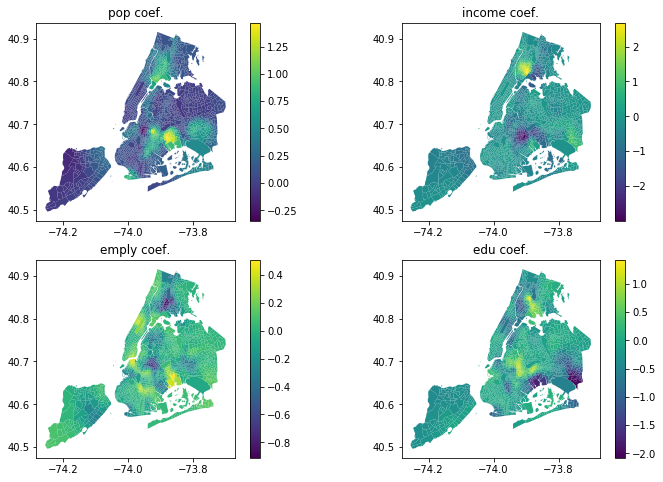

In [11]:
f,ax = plt.subplots(2,2,figsize=(12,8))
zone['pop_par'] = gwr_results.params[:, 1]
zone['income_par'] = gwr_results.params[:, 2]
zone['employ_par'] = gwr_results.params[:, 3]
zone['edu_par'] = gwr_results.params[:, 4]

ax1=plt.subplot(2, 2,1)
ax2=plt.subplot(2, 2,2)
ax3=plt.subplot(2, 2,3)
ax4=plt.subplot(2, 2,4)


zone.plot('pop_par',ax=ax1,legend = True)
ax1.set_title("pop coef.")
zone.plot('income_par',ax=ax2,legend = True)
ax2.set_title("income coef.")
zone.plot('employ_par',ax=ax3,legend = True)
ax3.set_title("emply coef.")
zone.plot('edu_par',ax=ax4,legend = True)
ax4.set_title("edu coef.")

f.savefig('GWRcoef.png', dpi=300)